In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Retina display
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

In [2]:
if os.path.exists('bear.jpg'):
    print('bear.jpg exists')
else:
    # !wget https://segment-anything.com/assets/gallery/FBB_Apartment_BE16_DSC03308.jpg -O salad.jpg
    !wget https://segment-anything.com/assets/gallery/GettyImages-673968470.jpg -O bear.jpg


bear.jpg exists


In [3]:
# Read in a image from torchvision
img = torchvision.io.read_image("bear.jpg")
print(img.shape)

torch.Size([3, 1450, 2068])


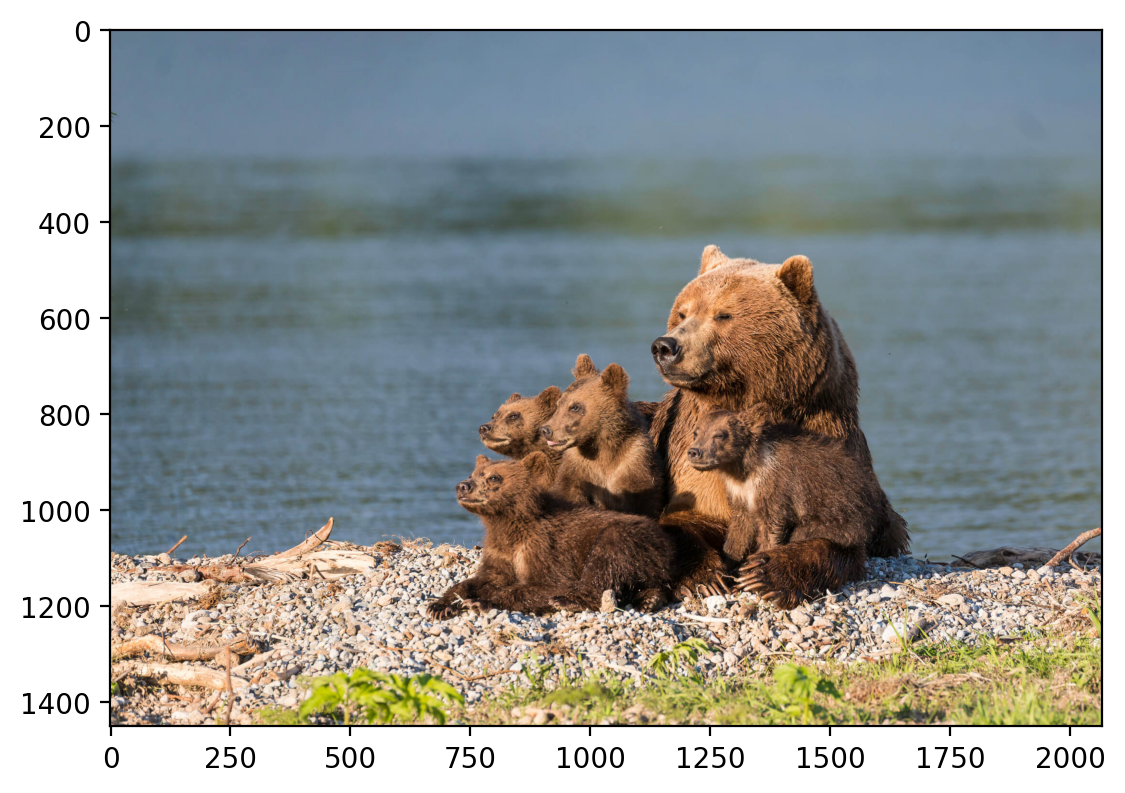

In [4]:
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())

In [5]:
from sklearn import preprocessing

scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
scaler_img

MinMaxScaler()

In [6]:
print("img shape:", img.shape)  

img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
img_scaled.shape
print("img_scaled shape:", img_scaled.shape)
img_scaled = torch.tensor(img_scaled)
img_scaled = img_scaled.to(device)

img shape: torch.Size([3, 1450, 2068])
img_scaled shape: (3, 1450, 2068)


crop shape: torch.Size([3, 350, 350])


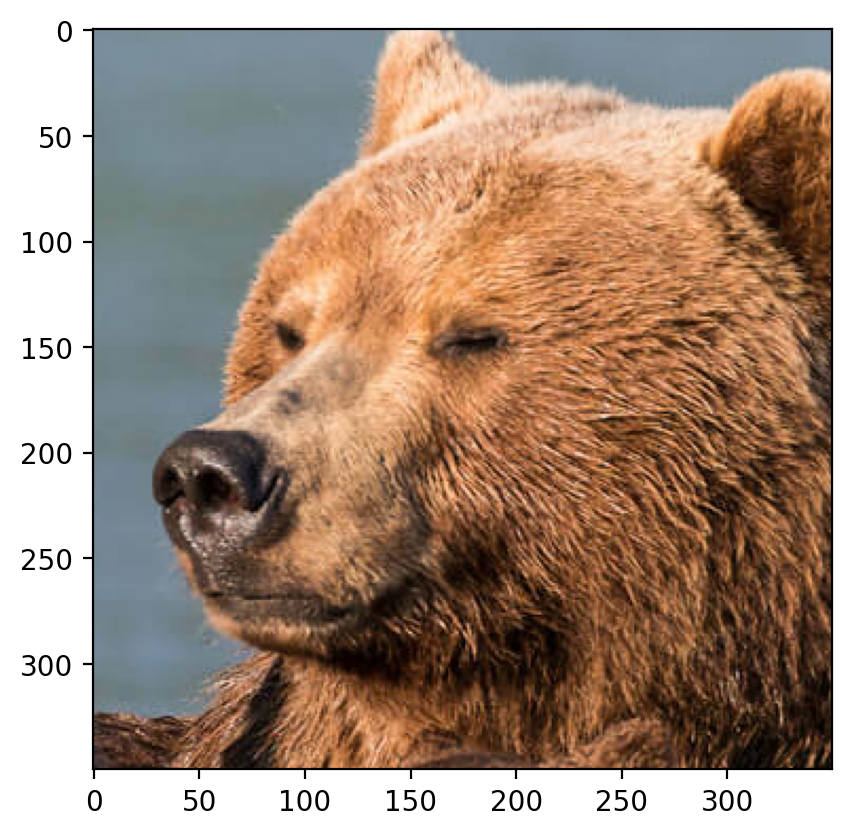

In [7]:
crop = torchvision.transforms.functional.crop(img_scaled.cpu(), 450, 1100, 350, 350)
print("crop shape:", crop.shape)
plt.imshow(rearrange(crop, 'c h w -> h w c').cpu().numpy())

In [8]:
crop = crop.to(device)
# Get the dimensions of the image tensor
num_channels, height, width = crop.shape
print(num_channels, height, width)

3 350 350


In [9]:
def create_coordinate_map(img):
    """
    img: torch.Tensor of shape (num_channels, height, width)
    
    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """
    
    num_channels, height, width = img.shape
    
    # Create a 2D grid of (x,y) coordinates (h, w)
    # width values change faster than height values
    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)

    # Reshape the image to (h * w, num_channels)
    Y = rearrange(img, 'c h w -> (h w) c').float()
    return X, Y

In [10]:
bear_X, bear_Y = create_coordinate_map(crop)

bear_X.shape, bear_Y.shape

(torch.Size([122500, 2]), torch.Size([122500, 3]))

In [11]:
# MinMaxScaler from -1 to 1
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(bear_X.cpu())

# Scale the X coordinates
bear_X_scaled = scaler_X.transform(bear_X.cpu())

# Move the scaled X coordinates to the GPU
bear_X_scaled = torch.tensor(bear_X_scaled).to(device)

# Set to dtype float32
bear_X_scaled = bear_X_scaled.float()

In [12]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)
        
    def forward(self, x):
        return self.linear(x)

In [13]:
net = LinearModel(2, 3)
net.to(device)

LinearModel(
  (linear): Linear(in_features=2, out_features=3, bias=True)
)

In [14]:
def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)
        
        
        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return loss.item()

In [15]:
train(net, 0.01, bear_X_scaled, bear_Y, 1000)

Epoch 0 loss: 0.846046
Epoch 100 loss: 0.045038
Epoch 200 loss: 0.029354
Epoch 300 loss: 0.029341
Epoch 400 loss: 0.029341
Epoch 500 loss: 0.029341
Epoch 600 loss: 0.029341
Epoch 700 loss: 0.029341
Epoch 800 loss: 0.029341
Epoch 900 loss: 0.029341


0.029340961948037148

In [16]:
def plot_reconstructed_and_original_image(original_img, net, X, title=""):
    """
    net: torch.nn.Module
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    num_channels, height, width = original_img.shape
    net.eval()
    with torch.no_grad():
        outputs = net(X)
        outputs = outputs.reshape(height, width, num_channels)
        #outputs = outputs.permute(1, 2, 0)
    fig = plt.figure(figsize=(6, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.imshow(outputs.cpu())
    ax0.set_title("Reconstructed Image")
    

    ax1.imshow(original_img.cpu().permute(1, 2, 0))
    ax1.set_title("Original Image")
    
    for a in [ax0, ax1]:
        a.axis("off")


    fig.suptitle(title, y=0.9)
    plt.tight_layout()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


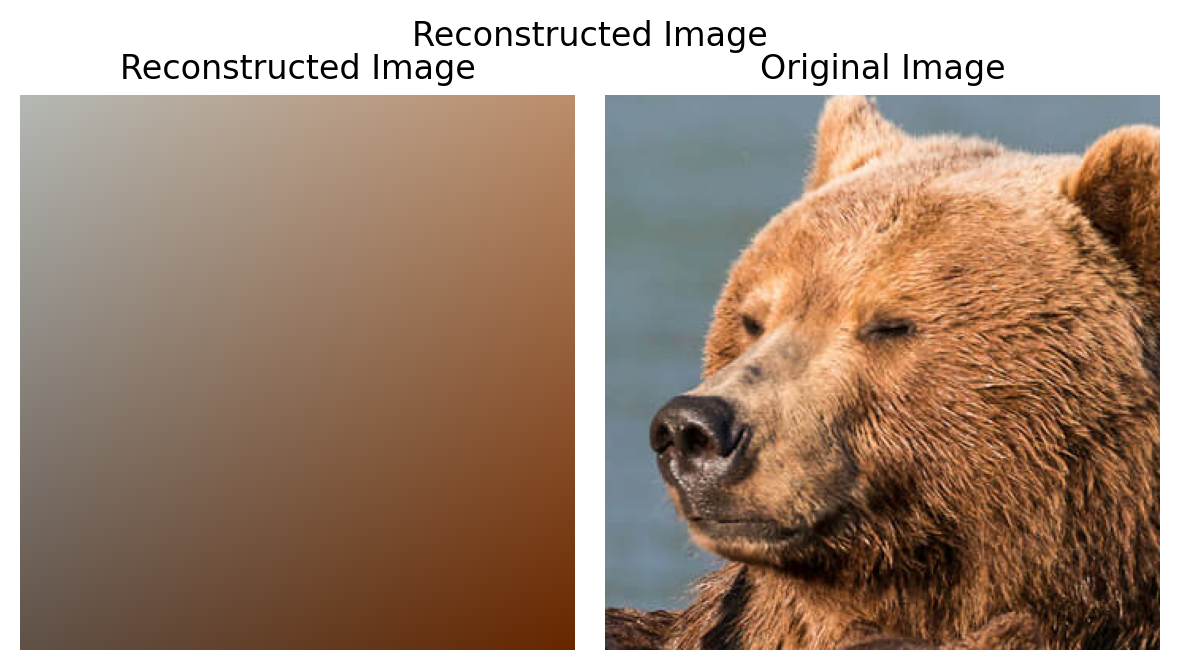

In [17]:
plot_reconstructed_and_original_image(crop, net, bear_X_scaled, title="Reconstructed Image")

In [18]:
def create_rff_features(X, num_features, sigma):
    from sklearn.kernel_approximation import RBFSampler
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2))
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32).to(device)

In [53]:
X_rff = create_rff_features(bear_X_scaled,16500, 0.006)

In [54]:
X_rff.shape

torch.Size([122500, 16500])

In [55]:
net = LinearModel(X_rff.shape[1], 3)
net.to(device)

train(net, 0.005, X_rff, bear_Y, 2500)

Epoch 0 loss: 0.257218
Epoch 100 loss: 0.043478
Epoch 200 loss: 0.029216
Epoch 300 loss: 0.026257
Epoch 400 loss: 0.024303
Epoch 500 loss: 0.022830


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.054146975..1.0629756].


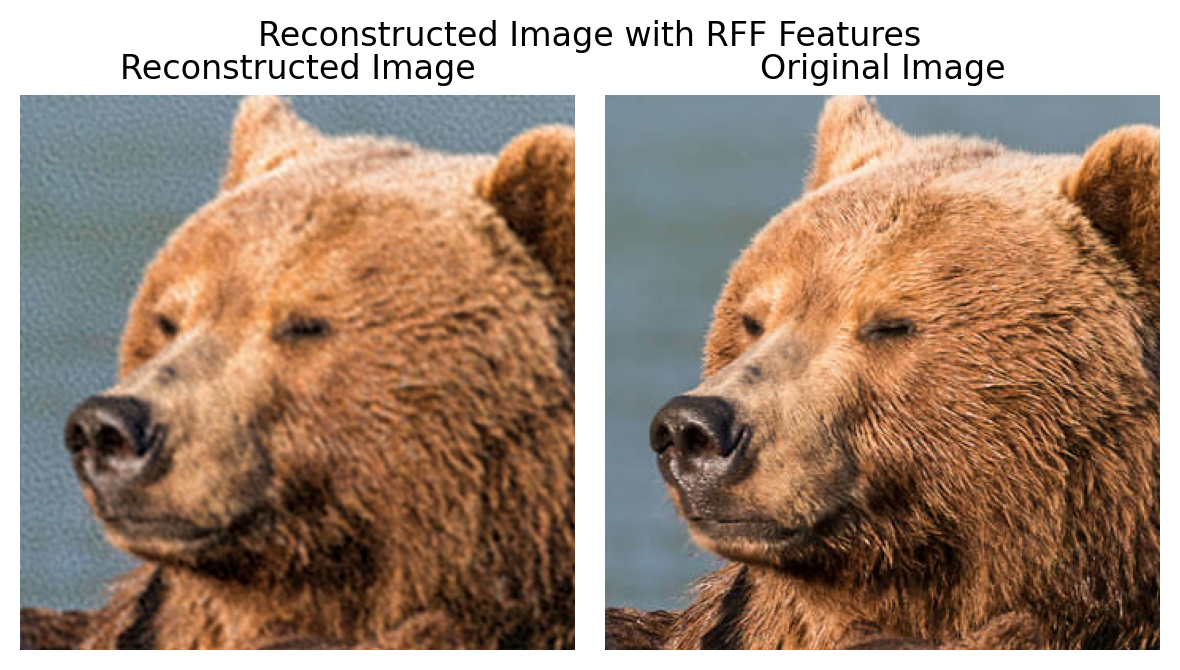

In [ ]:
plot_reconstructed_and_original_image(crop, net, X_rff, title="Reconstructed Image with RFF Features")